# $\verb|FishLSS|$ tutorial

In [1]:
# import revelant packages
import numpy as np
from classy import Class
import matplotlib.pyplot as plt

from FishLSS.fisherForecast import fisherForecast
from FishLSS.experiment import experiment

## (1) Setting up a $\verb|FishLSS|$ forecast

### (1a) The cosmology

A $\verb|FishLSS|$ forecast requires two main ingredients: a cosmology and an experiment. For the input cosmology, we use a $\verb|CLASS|$ object:

In [2]:
params = {'output': 'tCl lCl mPk',
          'l_max_scalars': 2500,
          'lensing': 'yes',
          'P_k_max_h/Mpc': 2.,
          'non linear':'halofit', 
          'z_pk': '0.0,1087',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'alpha_s': 0.,
          'h': 0.6770,
          'N_ur': 1.0196,
          'N_ncdm': 2,
          'm_ncdm': '0.01,0.05',
          'tau_reio': 0.0568,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923,
          'Omega_k': 0.}

cosmo = Class() 
cosmo.set(params) 
cosmo.compute() 

### (1b) The experiment

Now we specify the experiment, which is an instance of $\verb|experiment.py|$. At a minimum, we need to specify the redshift range of the survey ($z_\text{min}$ and $z_\text{max}$), the redshift binning, the sky coverage $f_\text{sky}$, the linear bias $b(z)$, and the number density $\bar{n}(z)$. The redshift binning can be specified in two ways: you can either input a `zedges` (numpy array) to specify the edges of the bins, or `nbins` (integer), in which case the redshift bins are assumed to be linearly spaced in $z$. Here we set `nbins = 3` for simplicity, so that we have three redshift bins with $\Delta z=1$.

In [3]:
# minimal set of inputs to an experiment object
zmin = 2.
zmax = 5.
nbins = 3
fsky = 0.5
b = lambda z: (1+z) 
n = lambda z: 3e-4 * np.exp(-(z-3.5)**2)

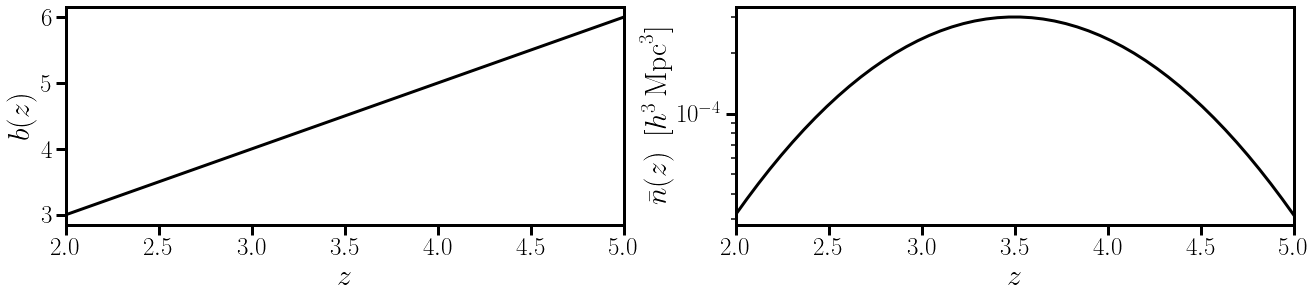

In [4]:
# for fun, let's take a look at the bias and number density
fig, ax = plt.subplots(1,2,figsize=(22,4))
zs = np.linspace(2,5,50)
ax[0].plot(zs,b(zs),lw=3,c='k')
ax[1].semilogy(zs,n(zs),lw=3,c='k')
for i in range(2): 
   ax[i].set_xlim(2,5)
   ax[i].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$b(z)$')
ax[1].set_ylabel(r'$\bar{n}(z)\,\,\,[h^3\,\text{Mpc}^3]$')
plt.show()

We can now create the experiment:

In [5]:
exp = experiment(zmin=zmin, zmax=zmax, nbins=nbins, fsky=fsky, b=b, n=n)

In addition to the above, one can optionally specify the following in an `experiment` object. The fiducial values of these variables can be found in the $\verb|experiment.py|$ file.
- If you want to run a forecast for one of following the experiments, you can set one of the following variables to `True`. Doing so is a shorthand for specifying $b(z)$ and $\bar{n}(z)$, following the conventions described in section 2 of  https://arxiv.org/abs/2106.09713 
    - `LBG` (boolean): idealized MegaMapper sample               
    - `HI` (boolean): 21-cm surveys                       
    - `ELG` (boolean): DESI ELG sample              
    - `Euclid` (boolean): Euclid H$\alpha$ sample   
    - `MSE` (boolean): MSE ELG + LBG sample 


- If you wish to use only the bias of one of the above surveys, and manually input the number density (or vice versa), then you can switch the following to `True`:
    - `custom_n` (boolean)
    - `custom_b` (boolean)

    
- You can specify further details of the tracer and survey with
    - `b2` (function of $z$): quadratic bias $b_2(z)$ of the tracer
    - `sigv` (float): the comoving velocity dispersion for FoG contributions [km/s]
    - `sigma_z` (float): redshift error $\sigma_z/(1+z)$
  
  
- For a 21-cm survey (`HI = True`), one may also wish to specify:
    - `pesimistic`: set to `False` for optimistic foreground assumptions (controls the foreground-wedge)
    - `Ndetectors`: number of antennas
    - `fill_factor`: area of the array's footprint that's occupied by dishes
    - `tint`: observing time [years]

### (1c) The forecast

### (1c) The forecast

With a cosmology and an experiment in hand, we can now create a forecast. Running the line below will create an `output` directory, as well as a subdirectory for the experiment of interest: `output/example` in this case. After creating these directories, $\verb|FishLSS|$ will calculate the fiducial power spectra ($P_{gg}(\boldsymbol{k},z)$ and $P_\text{recon}(\boldsymbol{k},z)$) at the center of each redshift bin, and store them in `output/example/derivatives/` and `output/example/derivatives_recon` respectively (assuming that the files don't already exist). $\verb|FishLSS|$ will also calculate $C^{\kappa\kappa}_\ell$, $C^{\kappa g_i}_\ell$ and $C^{g_i g_i}_\ell$ for each redshift bin, and save them in `output/example/derivatives_Cl`. 

Calculating the fiducial power spectra takes a little while ($\sim 10$ minutes for $3$ redshift bins), so go grab some coffee...

In [6]:
bd = '/path/to/where/you/want/to/store/derivatives/'
forecast = fisherForecast(experiment=exp,cosmo=cosmo,name='example',basedir=bd)

When creating a forecast, one can additionaly choose to set the following variables, whose fiducial values are given in $\verb|fisherForecast.py|$.

- domain
    - `kmin` (float): the minimum wavenumber [h/Mpc]
    - `kmax` (float): the maximum wavenumber [h/Mpc]
    - `Nmu` (int): number of $k$-bins
    - `Nk` (int): number of $\mu$-bins
    - `N2cut` (float):
    
- model
    - `velocileptors` (boolean):
    - `linear` (boolean):
    - `linear2` (boolean):
    
- EDE
    - `fEDE` 
    - `log10z_c`
    - `thetai_scf`

- primordial features
    - `A_lin`
    - `omega_lin`
    - `phi_lin`

Redshift-space power spectra are computed on a (flattened) $k-\mu$ grid. That is, $P_{gg}(\boldsymbol{k},z)$ is stored as an array of length `forecast.Nk * forecast.Nmu`, with the corresponding values of $k$ and $\mu$ stored in `forecast.k` and `forecast.mu`. 

Below (left) we plot the monopole and quadruple of $P_{gg}(\boldsymbol{k},z_i)$, evaluated at the center of the $i$'th redshift bin. We also plot (right) the fiducial lensing auto- and cross-spectra.  

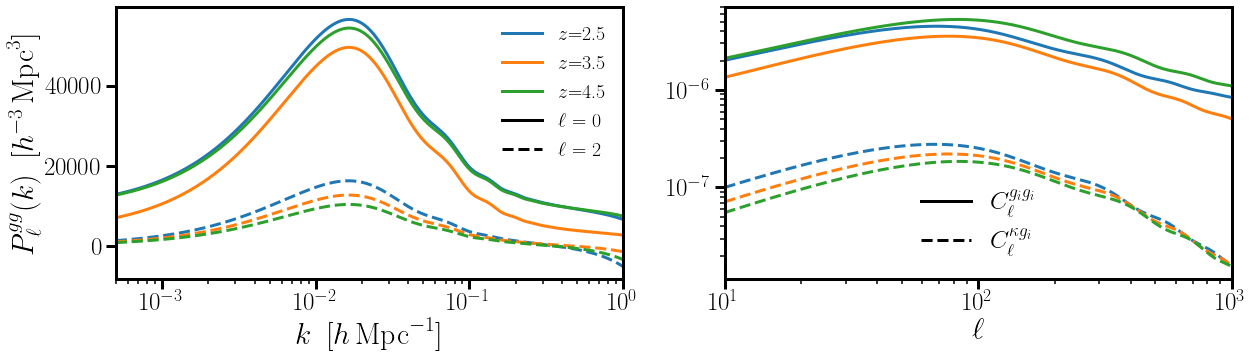

In [8]:
fix,ax = plt.subplots(1,2,figsize=(20,5))

k = forecast.k.reshape((forecast.Nk,forecast.Nmu))[:,0]
l = forecast.ell

for i in range(nbins): 
    z = forecast.experiment.zcenters[i]
    Pkmu = forecast.P_fid[i]
    P0 = forecast.LegendreTrans(0,Pkmu)
    P2 = forecast.LegendreTrans(2,Pkmu)
    ax[0].semilogx(k,P0,c='C'+str(i),lw=3,label=r'$z$='+str(z))
    ax[0].semilogx(k,P2,c='C'+str(i),lw=3,ls='--')
    ax[1].loglog(l,forecast.Cgg_fid[i],c='C'+str(i),lw=3)
    ax[1].loglog(l,forecast.Ckg_fid[i],c='C'+str(i),lw=3,ls='--')

ax[0].set_xlim(forecast.kmin,forecast.kmax)
ax[0].set_xlabel(r'$k\,\,\,[h\,\text{Mpc}^{-1}]$')
ax[0].set_ylabel(r'$P^{gg}_\ell(k)\,\,\,[h^{-3}\,\text{Mpc}^{3}]$')
ax[0].semilogx([],[],lw=3,c='k',label=r'$\ell=0$')
ax[0].semilogx([],[],lw=3,c='k',ls='--',label=r'$\ell=2$')
ax[0].legend(loc='upper right',frameon=False,fontsize=20)
#
ax[1].set_xlim(10,1000)
ax[1].set_xlabel(r'$\ell$')
ax[1].semilogx([],[],lw=3,c='k',label=r'$C^{g_ig_i}_\ell$')
ax[1].semilogx([],[],lw=3,c='k',ls='--',label=r'$C^{\kappa g_i}_\ell$')
ax[1].legend(frameon=False)
plt.show()

talk about how to generally just call for the power spectrum/

## (2) Computing derivatives

### (2a) Full shape measurements

In [9]:
basis_Pkmu = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio',\
                    'm_ncdm','N_ur','alpha_s','Omega_k','f_NL','N','alpha0',\
                    'b','b2','bs','N2','N4','alpha2','alpha4'])
forecast.free_params = basis_Pkmu

In [ ]:
forecast.compute_derivatives()

### (2b) Lensing and cross-correlations

In [ ]:
basis_Cl = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio',\
                    'm_ncdm','N_ur','alpha_s','Omega_k','f_NL','N','alpha0',\
                    'alphax','b','b2','bs','gamma'])
forecast.free_params = basis_Cl
#
forecast.compute_Cl_derivatives()

## (3) Computing Fisher matrices

In [ ]:
derivatives_Pkmu = forecast.load_derivatives(basis_Pkmu)

In [ ]:
F_Pkmu = forecast.gen_fisher(basis_Pkmu,11,kmax_knl=1,derivatives=derivatives_Pkmu)

In [ ]:
F_Cl = forecast.gen_lensing_fisher(basis_Cl,11,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')

## (4) CMB priors

$\Lambda\text{CDM}$ + $M_\nu$ + $N_\text{eff}$ + $\Omega_k$

$\{h,\,\ln(A_s),\,n_s,\,\omega_c,\,\omega_b,\,\tau,\,M_\nu,\,N_\text{eff},\,\alpha_s,\,\Omega_k,\,f_\text{NL}^\text{Loc}\}$

In [43]:
F_Planck = np.genfromtxt('input/Planck.txt')
F_Planck_SO = np.genfromtxt('input/Planck_SO.txt')
F_Planck_S4 = np.genfromtxt('input/Planck_S4.txt')
F_LiteBIRD_S4 = np.genfromtxt('input/LiteBIRD_S4.txt')
F_LiteBIRD_S4 = np.genfromtxt('input/LiteBIRD_SO.txt')

## (5) Combined forecasts

In [ ]:
F = fishcast.combine_fishers([F_Planck_SO,F_Pkmu,F_Cl],11)

maybe make a triangle plot or something?